- This study focus in analysing the relation of inflation in Brazil, with *SOME* of the main factors, for the lack of reliable datasets to support all the causations, accordingly with economics theory, and to keep the attention in the main indexes.
- Factors used: 
Interest Rate (IR); 
Money Supply (MS); 
Minimum Wages (MW); 
General Government Debt (GD); 
partial inflation rates that forms the final index (Inflation aggregates). All Datasets was downloaded from the Central Bank of Brazil.   


## Data Preprocessing

In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split 

pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 10)

In [64]:
# Importing the Datasets
ir = pd.read_csv('IR.csv', sep=';', encoding='latin-1')
ms = pd.read_csv('MS.csv', sep=';', encoding='latin-1', thousands='.')
mw = pd.read_csv('MW.csv', sep=';', encoding='latin-1', thousands='.')
gd = pd.read_csv('GD.csv', sep=';', encoding='latin-1', thousands='.')
inflation = pd.read_csv('INFLATION.csv', sep=';', encoding='latin-1')

In [65]:
# Renaming the Columns
ir.rename(columns = {'Data':'date', '4390 - Taxa de juros - Selic acumulada no mês - % a.m.':'int_rate'}, inplace=True)
ms.rename(columns = {'Data':'date', '1786 - BM - Papel moeda emitido (saldo em final de período) - u.m.c. (mil)':'money_supply'}, inplace=True)
mw.rename(columns = {'Data':'date', '1619 - Salário mínimo - u.m.c.':'min_wages'}, inplace=True)
gd.rename(columns = {'Data':'date', '4501 - Divida líquida do governo geral - Saldos em R$ milhões - R$ (milhões)':'gov_debt'}, inplace=True)
inflation.rename(columns = {'Data':'date', '433 - Índice nacional de preços ao consumidor-amplo (IPCA) - Var. % mensal':'inflation',
                            '1635 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Alimentação e bebidas - Var. % mensal':'food',
                            '1636 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Habitação - Var. % mensal':'housing',
                            '1637 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Artigos de residência - Var. % mensal':'house_items',
                            '1638 - Índice nacional de preços ao consumidor-Amplo (IPCA)- Vestuário - Var. % mensal':'clothing',
                            '1639 - Índice de nacional de preços ao consumidor-Amplo (IPCA) - Transportes - Var. % mensal':'transport',
                            '1640 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Comunicação - Var. % mensal':'communication',
                            '1641 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Saúde e cuidados pessoais - Var. % mensal':'health',
                            '1642 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Despesas pessoais - Var. % mensal':'personal',
                            '1643 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Educação - Var. % mensal': 'education'}, inplace=True)

In [66]:
# Cropping the Dates, from January/2000 to October/2021

# IR
ir_01 = ir[162:424]
ir_01.reset_index(drop=True, inplace=True)

# MS
ms_01 = ms[240:502]
ms_01.reset_index(drop=True, inplace=True)


# MW
mw_01 = mw[120:382]
mw_01.reset_index(drop=True, inplace=True)


# GD
gd_01 = gd[24:286]
gd_01.reset_index(drop=True, inplace=True) 


# Inflation
inflation_01 = inflation[240:502]
inflation_01.reset_index(drop=True, inplace=True)


In [67]:
# Merging all the cropped datasets
Cropped = inflation_01.merge(ir_01, on='date')
Cropped1 = Cropped.merge(ms_01, on='date')
Cropped2 = Cropped1.merge(mw_01, on='date') 
Cropped3 = Cropped2.merge(gd_01, on='date')

# Changing Columns order
Cropped3 = Cropped3.reindex(columns = ['date','int_rate','money_supply', 'min_wages', 'gov_debt', 'food',
                                       'housing', 'house_items', 'clothing', 'transport','communication',
                                       'health', 'personal', 'education', 'inflation'])
Cropped3.drop('date', axis=1, inplace=True)


# Exporting the formatted dataset
Cropped3.to_csv('dataset.csv', index=False)
dataset = pd.read_csv('dataset.csv', thousands='.', decimal=',')

dataset

,int_rate,money_supply,min_wages,gov_debt,food,housing,house_items,clothing,transport,communication,health,personal,education,inflation
0,1.46,24199689,136.00,492136.23,0.84,0.19,0.43,0.21,0.39,1.82,0.59,0.12,3.05,0.62
1,1.45,23068674,136.00,494285.94,-0.25,0.01,0.29,-0.67,0.40,0.04,0.22,0.36,1.32,0.13
2,1.45,22732484,136.00,493089.13,-0.46,0.17,0.28,-1.44,1.68,0.07,0.27,-0.07,-0.26,0.22
3,1.30,23279829,151.00,500897.64,-0.36,0.00,0.19,0.72,0.51,-0.29,0.07,3.55,0.01,0.42
4,1.49,22470333,151.00,505608.51,-0.67,0.45,0.25,0.35,0.13,0.18,0.03,0.13,0.07,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,0.31,340095553,1100.00,5133428.61,0.43,1.10,1.09,1.21,0.41,-0.12,0.51,0.29,0.05,0.53
258,0.36,343812587,1100.00,5191114.72,0.60,3.10,0.78,0.53,1.52,0.12,-0.65,0.45,0.18,0.96
259,0.43,341302698,1100.00,5212554.57,1.39,0.68,0.99,1.02,1.46,0.23,-0.04,0.64,0.28,0.87
260,0.44,336844324,1100.00,5262849.94,1.02,2.56,0.90,0.31,1.82,0.07,0.39,0.56,-0.01,1.16


 ## EDA


In [68]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   int_rate       262 non-null    float64
 1   money_supply   262 non-null    int64  
 2   min_wages      262 non-null    float64
 3   gov_debt       262 non-null    float64
 4   food           262 non-null    float64
 5   housing        262 non-null    float64
 6   house_items    262 non-null    float64
 7   clothing       262 non-null    float64
 8   transport      262 non-null    float64
 9   communication  262 non-null    float64
 10  health         262 non-null    float64
 11  personal       262 non-null    float64
 12  education      262 non-null    float64
 13  inflation      262 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 28.8 KB


In [69]:
dataset.describe()

,int_rate,money_supply,min_wages,gov_debt,food,housing,house_items,clothing,transport,communication,health,personal,education,inflation
count,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00
mean,0.96,141142973.18,570.75,1913657.79,0.61,0.56,0.30,0.43,0.47,0.32,0.50,0.56,0.55,0.51
std,0.40,91219940.13,304.50,1305104.17,0.83,0.70,0.54,0.57,0.88,1.11,0.41,0.45,1.33,0.39
min,0.13,22470333.00,136.00,492136.23,-1.07,-2.38,-1.37,-1.44,-2.66,-1.65,-0.71,-0.25,-3.47,-0.38
25%,0.68,55632399.25,300.00,970264.49,0.07,0.23,-0.03,0.08,-0.03,-0.01,0.32,0.29,0.04,0.26
50%,0.94,133103061.00,510.00,1481819.22,0.58,0.48,0.29,0.47,0.34,0.07,0.43,0.50,0.13,0.45
75%,1.23,205271965.00,880.00,2484994.07,1.03,0.77,0.56,0.85,0.78,0.28,0.64,0.71,0.35,0.69
max,2.08,370441036.00,1100.00,5289723.28,5.85,5.29,2.88,1.91,4.68,9.31,2.74,3.55,6.70,3.02


In [ ]:
# Distributions of the columns
for columns in dataset.columns:
  sns.set_style('dark')
  sns.displot(dataset[columns], kde=True, bins=40, height=5, aspect=1)
  plt.title(columns)
  plt.show(columns)
  
  

<AxesSubplot:>

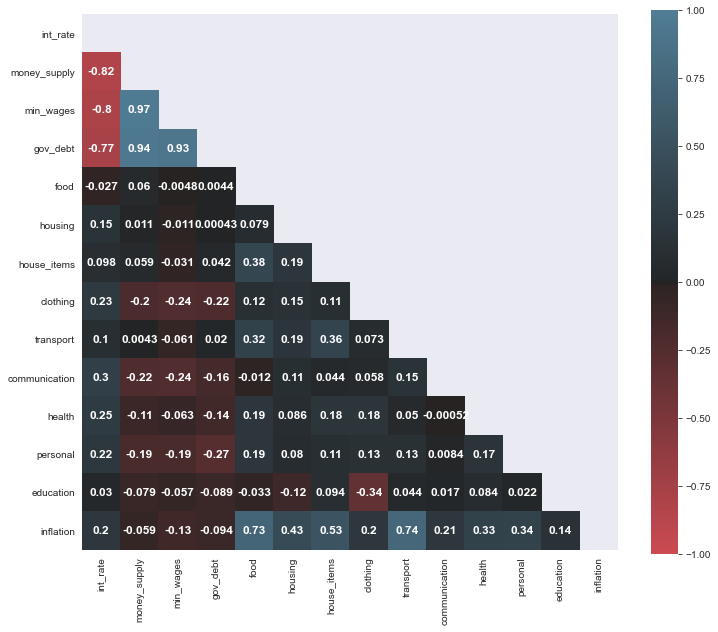

In [71]:
# Correlations map
plt.figure(figsize=(12,10))
mask = np.triu(np.ones_like(dataset.corr()))
cmap = sns.diverging_palette(10, 230, as_cmap=True, center="dark", s=60)
sns.heatmap(dataset.corr(), cmap=cmap, square=True, center=0, vmin=-1, vmax=1, 
            annot=True, mask=mask, annot_kws={'fontsize':12, 'fontweight':'bold'})

## Data Splits

In [72]:
# Target/Label split
y = dataset['inflation']
y

0     0.62
1     0.13
2     0.22
3     0.42
4     0.01
      ... 
257   0.53
258   0.96
259   0.87
260   1.16
261   1.25
Name: inflation, Length: 262, dtype: float64

In [94]:
# Features split
X = dataset.iloc[:, :-1]
X

,int_rate,money_supply,min_wages,gov_debt,food,housing,house_items,clothing,transport,communication,health,personal,education
0,1.46,24199689,136.00,492136.23,0.84,0.19,0.43,0.21,0.39,1.82,0.59,0.12,3.05
1,1.45,23068674,136.00,494285.94,-0.25,0.01,0.29,-0.67,0.40,0.04,0.22,0.36,1.32
2,1.45,22732484,136.00,493089.13,-0.46,0.17,0.28,-1.44,1.68,0.07,0.27,-0.07,-0.26
3,1.30,23279829,151.00,500897.64,-0.36,0.00,0.19,0.72,0.51,-0.29,0.07,3.55,0.01
4,1.49,22470333,151.00,505608.51,-0.67,0.45,0.25,0.35,0.13,0.18,0.03,0.13,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,0.31,340095553,1100.00,5133428.61,0.43,1.10,1.09,1.21,0.41,-0.12,0.51,0.29,0.05
258,0.36,343812587,1100.00,5191114.72,0.60,3.10,0.78,0.53,1.52,0.12,-0.65,0.45,0.18
259,0.43,341302698,1100.00,5212554.57,1.39,0.68,0.99,1.02,1.46,0.23,-0.04,0.64,0.28
260,0.44,336844324,1100.00,5262849.94,1.02,2.56,0.90,0.31,1.82,0.07,0.39,0.56,-0.01


In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7 ,random_state=1)

## Modeling

In [119]:
# Regression Model 
model = linear_model.LinearRegression() # defines the regression Model
model.fit(X_train, y_train) # build training model
y_pred = model.predict(X_test) # apply trained model to predict

In [102]:
# Prediction Results
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.4f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination (R^2): %.4f' % r2_score(y_test, y_pred))

Coefficients: [-5.62241265e-03 -1.85389484e-10  6.08924555e-05 -3.07791846e-09
  2.30037150e-01  1.52551519e-01  5.26850096e-02  5.49617647e-02
  2.06178763e-01  3.69748722e-02  1.20359416e-01  1.06724109e-01
  5.34901091e-02]
Intercept: -0.008604731224762685
Mean squared error (MSE): 0.0005
Coefficient of determination (R^2): 0.9975


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='inflation'>

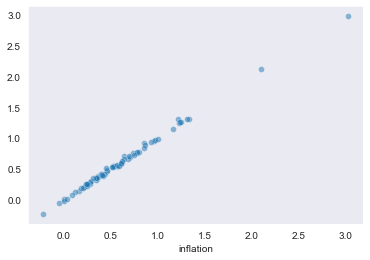

In [122]:
sns.scatterplot(y_test, y_pred, alpha=.5)